# Simgle Image Image Classification

**Note**: The colab notebook follows tutorials from pyimagesearch.com
1. siamese network: 
https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/
2. turning object classification network to object detection:
https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

### Contents:
#### 1. Making pairs (building dataset for siamese network)
#### 2. Build Neural Network
#### 3. Train Neural Network
#### 4. Save Model
#### 5. Load Model and Test Model


## Making Pairs

### Imports

In [ ]:
from tensorflow.keras.datasets import mnist
from imutils import build_montages
import numpy as np
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow

### function to make pairs of images

In [ ]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

### load data and make pairs

In [ ]:
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
print(trainX.shape, testX.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)
images = []
print(pairTrain.shape, pairTest.shape)

(120000, 2, 28, 28, 1) (20000, 2, 28, 28, 1)


## Build Neural Network

### Imports

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

### Network

In [ ]:
def build_siamese_model(inputShape, flow, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape, name=flow+"input")
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu", name=flow+"_conv1")(inputs)
	x = MaxPooling2D(pool_size=(2, 2), name=flow+"_pool1")(x)
	x = Dropout(0.3, name=flow+"_drop1")(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu", name=flow+"_conv2")(x)
	x = MaxPooling2D(pool_size=2, name=flow+"_pool2")(x)
	x = Dropout(0.3, name=flow+"_drop2")(x)
  # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D(name=flow+"_pooled_out")(x)
	outputs = Dense(embeddingDim, name=flow+"_embed")(pooledOutput)
	# build the model
	model = Model(inputs, outputs, name="feature_extractor_model")
	# return the model to the calling function
	return model

In [ ]:
siamese_model = build_siamese_model([28,28,1], "flow")

In [ ]:
siamese_model.summary()

Model: "feature_extractor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flowinput (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
flow_conv1 (Conv2D)          (None, 28, 28, 64)        320       
_________________________________________________________________
flow_pool1 (MaxPooling2D)    (None, 14, 14, 64)        0         
_________________________________________________________________
flow_drop1 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flow_conv2 (Conv2D)          (None, 14, 14, 64)        16448     
_________________________________________________________________
flow_pool2 (MaxPooling2D)    (None, 7, 7, 64)          0         
_________________________________________________________________
flow_drop2 (Dropout)         (None, 7, 7, 6

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

## Train Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np
import os

In [ ]:
IMG_SHAPE = (28, 28, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 100
MODEL_PATH = os.path.sep.join(["out", "siamese_model"])
PLOT_PATH = os.path.sep.join(["out", "plot.png"])

In [ ]:
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

[INFO] preparing positive and negative pairs...


In [ ]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE, "flow")
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [ ]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

[INFO] training model...
Epoch 1/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6220 - accuracy: 0.6429 - val_loss: 0.5632 - val_accuracy: 0.7315
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5423 - accuracy: 0.7336 - val_loss: 0.4776 - val_accuracy: 0.7872
Epoch 3/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4977 - accuracy: 0.7613 - val_loss: 0.4471 - val_accuracy: 0.8030
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4744 - accuracy: 0.7751 - val_loss: 0.4223 - val_accuracy: 0.8117
Epoch 5/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4556 - accuracy: 0.7871 - val_loss: 0.3950 - val_accuracy: 0.8278
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4391 - accuracy: 0.7961 - val_loss: 0.3879 - val_accuracy: 0.8300
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4239 - accuracy: 0.

## Save model

In [ ]:
model.save(MODEL_PATH)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: out/siamese_model/assets


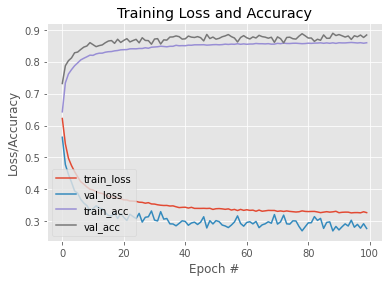

In [ ]:
plot_training(history, PLOT_PATH)


## Load and Test model

In [1]:
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
model = load_model("./out/siamese_model/")

In [ ]:
!unzip test.zip

Archive:  test.zip
 extracting: test/0.jpg              
  inflating: test/1.jpg              
  inflating: test/10.jpg             
  inflating: test/11.jpg             
 extracting: test/12.jpg             
  inflating: test/13.jpg             
  inflating: test/14.jpg             
  inflating: test/15.jpg             
  inflating: test/16.jpg             
  inflating: test/17.jpg             
  inflating: test/18.jpg             
  inflating: test/19.jpg             
 extracting: test/2.jpg              
  inflating: test/3.jpg              
 extracting: test/4.jpg              
  inflating: test/5.jpg              
  inflating: test/6.jpg              
 extracting: test/7.jpg              
  inflating: test/8.jpg              
  inflating: test/9.jpg              


In [ ]:
test_path = "./test/"
image_paths = ["./test/"+w for w in os.listdir(test_path)]
from itertools import combinations
pairs = [w for w in combinations(image_paths, 2)][:5]

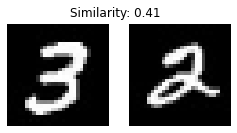

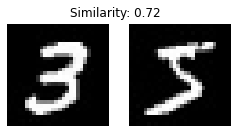

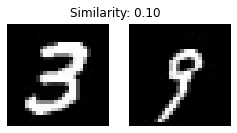

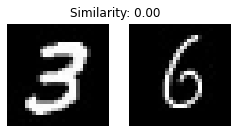

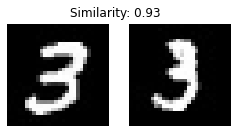

In [ ]:
for (i, (pathA, pathB)) in enumerate(pairs):
  # load both the images and convert them to grayscale
  imageA = cv2.imread(pathA, 0)
  imageB = cv2.imread(pathB, 0)
  # create a copy of both the images for visualization purpose
  origA = imageA.copy()
  origB = imageB.copy()
  # add channel a dimension to both the images
  imageA = np.expand_dims(imageA, axis=-1)
  imageB = np.expand_dims(imageB, axis=-1)
  # add a batch dimension to both images
  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis=0)
  # scale the pixel values to the range of [0, 1]
  imageA = imageA / 255.0
  imageB = imageB / 255.0
  # use our siamese model to make predictions on the image pair,
  # indicating whether or not the images belong to the same class
  preds = model.predict([imageA, imageB])
  proba = preds[0][0]
  fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
  plt.suptitle("Similarity: {:.2f}".format(proba))
  # show first image
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(origA, cmap=plt.cm.gray)
  plt.axis("off")
  # show the second image
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(origB, cmap=plt.cm.gray)
  plt.axis("off")
  # show the plot
  plt.show()

# Convert Object Classification to Object Detection Model
### Contents
#### 1. Construct Image Pramid
#### 2. Run sliding window for each scale and record box, label if confidence > threshold
#### 3. Build Datasetto calculate probabilities of each window
#### 4. Run model on extracted sliding window + pyramid images
#### 5. Non Max Supression with OpenCV

## Construct Image Pyramid

In [6]:
import imutils
import time
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression

In [7]:
WIDTH = 28
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (28,28)
INPUT_SIZE = (28, 28)

In [8]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

In [ ]:
orig = cv2.imread("./6.jpg")
H,W,_ = orig.shape
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
rois = []
locs = []

## Sliding Window

In [9]:
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [ ]:
# loop over the image pyramid
for image in pyramid:
  # determine the scale factor between the *original* image
  # dimensions and the *current* layer of the pyramid
  scale = W / float(image.shape[1])
  # for each layer of the image pyramid, loop over the sliding
  # window locations
  print("#")
  for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
    # scale the (x, y)-coordinates of the ROI with respect to the
    # *original* image dimensions
    print(len(rois))
    x = int(x * scale)
    y = int(y * scale)
    w = int(ROI_SIZE[0] * scale)
    h = int(ROI_SIZE[1] * scale)
    roi = cv2.resize(roiOrig, (28,28))
    rois.append(roi)
    locs.append((x, y, w, h))
    clone = orig.copy()
    cv2.rectangle(clone, (x, y), (x + w, y + h),
      (0, 255, 0), 2)
    # show the visualization and current ROI
    cv2_imshow(clone)
    cv2_imshow(roi)

## Build Dataset to calculate probabilities of an each window

In [10]:
def preprocess_img(im):
  # print(im.shape)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im = cv2.resize(im, (28,28))
  im = np.expand_dims(im, axis=-1)
  # print("here: ",im.shape)
  return im

In [ ]:
cls_img = cv2.imread("./7.jpg", 0)
cls_img = np.expand_dims(cls_img, axis=-1)
# cls_img = preprocess_img(cls_img)
cls_img = np.array([cls_img]*len(rois))
print(cls_img.shape)
inputs = [preprocess_img(im) for im in rois]
inputs = np.array(inputs)
inputs = inputs/255.0
cls_img = cls_img/255.0
print(inputs.shape)

(480, 28, 28, 1)
(480, 28, 28, 1)


## Run model on extracted sliding window + pyramid images

In [ ]:
preds = model.predict([inputs, cls_img])

In [ ]:
confidences = [float(w[0]) for w in preds]

## Non Max Suppression

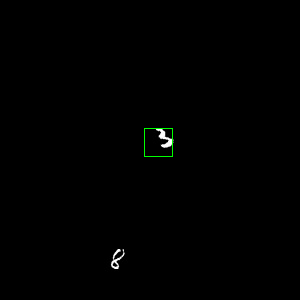

In [ ]:
orig = cv2.imread("./6.jpg")
indices = cv2.dnn.NMSBoxes(locs, confidences, 0.5, 0.2)
for i in indices:
  i = i [0]
  x,y,w,h = locs[i]
  cv2.rectangle(orig, (x,y),(x+w, y+h), (0,255,0))
cv2_imshow(orig)

In [ ]:
import pickle
with open("locations.pickle", 'wb') as f:
  pickle.dump(locs, f)
with open("confidences.pickle", 'wb') as f:
  pickle.dump(confidences, f)

In [ ]:
%%shell
zip -r model.zip out

  adding: out/ (stored 0%)
  adding: out/siamese_model/ (stored 0%)
  adding: out/siamese_model/variables/ (stored 0%)
  adding: out/siamese_model/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: out/siamese_model/variables/variables.index (deflated 64%)
  adding: out/siamese_model/saved_model.pb (deflated 90%)
  adding: out/siamese_model/assets/ (stored 0%)
  adding: out/plot.png (deflated 5%)


## Calcuate MAP

In [12]:
def preprocess_img(im):
  # print(im.shape)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im = cv2.resize(im, (28,28))
  im = np.expand_dims(im, axis=-1)
  # print("here: ",im.shape)
  return im

In [13]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

In [14]:
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [59]:
def object_detection(orig, cls_img):
  H,W,_ = orig.shape
  pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
  rois = []
  locs = []
  for image in pyramid:
  # determine the scale factor between the *original* image
  # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
      # scale the (x, y)-coordinates of the ROI with respect to the
      # *original* image dimensions
      x = int(x * scale)
      y = int(y * scale)
      w = int(ROI_SIZE[0] * scale)
      h = int(ROI_SIZE[1] * scale)
      roi = cv2.resize(roiOrig, (28,28))
      rois.append(roi)
      locs.append((x, y, w, h))
  # cls_img = cv2.imread("./7.jpg", 0)
  cls_img = np.expand_dims(cls_img, axis=-1)
  cls_img = np.array([cls_img]*len(rois))
  inputs = [preprocess_img(im) for im in rois]
  inputs = np.array(inputs)
  inputs = inputs/255.0
  cls_img = cls_img/255.0
  preds = model.predict([inputs, cls_img])
  confidences = [float(w[0]) for w in preds]
  orig = cv2.imread("./6.jpg")
  indices = cv2.dnn.NMSBoxes(locs, confidences, 0.65, 0.2)
  result = []
  for i in indices:
    i = i [0]
    x,y,w,h = locs[i]
    cv2.rectangle(orig, (x,y),(x+w, y+h), (0,255,0))
    result.append([confidences[i], x, y, x+w, y+h])
  return result

In [ ]:
# save format is: <class_name> <confidence> <left> <top> <right> <bottom>
import os
images = ["./dataset/"+w for w in os.listdir("./dataset") if w.endswith(".jpg")]
annotations=[]
cls_img = cv2.imread("./7.jpg", 0)
for im in images:
  print(im)
  orig = cv2.imread(im)
  result = object_detection(orig, cls_img)
  annotations.append([im,result])

In [ ]:
[w for w in annotations if len(w[1])>0]

In [62]:
%%shell
rm -r annotations
mkdir annotations
rm result.zip

In [ ]:
for obj in annotations:
  file_name = obj[0]
  positions = obj[1]
  if len(positions)==0:
    continue
  file_name = file_name.replace("./dataset/",'').replace(".jpg", ".txt")
  with open("annotations/"+file_name, 'w') as f:
    lines = ["3 %.6f %d %d %d %d"%(w[0], int(w[1]), int(w[2]), int(w[3]), int(w[4])) for w in positions]
    print(lines)
    f.write("\n".join(lines))

In [ ]:
%%shell
zip -r result.zip annotations